In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
import re
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
shap.initjs()

print("✅ Libraries Loaded. Ready for Customer Service mode.")

/Users/kaixinxie/Credit_Risk_forCapgemini/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries Loaded. Ready for Customer Service mode.


In [3]:
xgb_model = joblib.load('../models/champion_model.joblib')
model = xgb_model 
feature_names = joblib.load('../models/model_features.joblib') 
print(f"✅ Loaded Champion Model: {type(xgb_model).__name__}")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
print(f"✅ Loaded Data. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

✅ Loaded Champion Model: CalibratedClassifierCV
✅ Loaded Data. Train Shape: (957145, 41), Test Shape: (94893, 41)


In [7]:
import pandas as pd
import re

# 1. 强制清理当前数据框的列名 (防止有空格或特殊字符残留)
def sanitize_feature_names(df):
    new_cols = []
    for col in df.columns:
        # 替换所有非字母、数字和下划线的字符
        new_col = re.sub(r'[\s\[\]<]', '_', col).strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_train = sanitize_feature_names(X_train)
X_test = sanitize_feature_names(X_test)
print("✅ Current feature names sanitized.")

# 2. 识别并创建缺失的特征 (One-Hot 编码常见问题)
# 这一步是为了处理在训练集和测试集中，某些 One-Hot 编码特征未出现的问题。
missing_in_train = set(feature_names) - set(X_train.columns)
missing_in_test = set(feature_names) - set(X_test.columns)

# 强制添加缺失的列，并用 0 填充（通常用于 One-Hot 编码特征）
for col in missing_in_train:
    X_train[col] = 0
for col in missing_in_test:
    X_test[col] = 0

if missing_in_train or missing_in_test:
    print(f"⚠️ Added {len(missing_in_train)} missing columns (set to 0) to X_train.")
    print(f"⚠️ Added {len(missing_in_test)} missing columns (set to 0) to X_test.")
    
# 3. 重新执行特征重排 (Reindexing)
# 现在列名已清理，并且所有需要的列都已存在（即使值是 0）

X_train = X_train[feature_names]
X_test = X_test[feature_names]
print("✅ Features successfully realigned to match model's expected order and names.")

y_prob = model.predict_proba(X_test)[:, 1]
X_analysis = X_test.copy()
X_analysis['prob'] = y_prob

# 4. 最终检查
if X_train.shape[1] == len(feature_names):
    print(f"✨ Final check successful. Feature count: {X_train.shape[1]}")
else:
    print("❌ Final feature count mismatch! Check dropped columns.")

✅ Current feature names sanitized.
✅ Features successfully realigned to match model's expected order and names.
✨ Final check successful. Feature count: 41


### 1. Find "borderline rejected" customers within the target range

In [52]:
# ----------------------------------------------------------------------
# Assume X_analysis contains the index of X_test and the predicted probabilities (prob column)
# Assume X_test is the original feature set (already aligned)
# ----------------------------------------------------------------------

# ==========================================
# 2. Find "borderline rejected" customers within the target range
# ==========================================

# Define target probability range
TARGET_PROB_MIN = 0.05  # 5%
TARGET_PROB_MAX = 0.06  # 6%
# Assume the business optimal threshold THRESHOLD is already defined (e.g., from your NB 02)
# If THRESHOLD is not defined, we can assume 5%
THRESHOLD = 0.050 

print(f"🔍 Searching for customers with predicted probability between {TARGET_PROB_MIN:.0%} - {TARGET_PROB_MAX:.0%}...")

# 1. Create filter mask
borderline_mask = (X_analysis['prob'] >= TARGET_PROB_MIN) & (X_analysis['prob'] <= TARGET_PROB_MAX)
candidates = X_analysis[borderline_mask]

if not candidates.empty:
    # 2. Select the first candidate customer
    customer_idx = candidates.index[0]
    customer_data = X_test.loc[[customer_idx]]  # Keep as DataFrame, used for LIME
    customer_prob = candidates.loc[customer_idx, 'prob']
    
    # 3. Determine rejection status
    status = "REJECTED" if customer_prob > THRESHOLD else "APPROVED"
    
    print("-" * 40)
    print(f"🎯 Selected Customer Index: {customer_idx}")
    print(f"📈 Prediction: {customer_prob:.2%} (Decision Threshold: {THRESHOLD:.0%}) -> {status}")
    print("\n--- Customer Profile (Top 10 Features) ---")
    # Print the customer's top 10 features and their values
    print(customer_data.T.head(10).to_markdown(numalign="right"))
    print("-" * 40)
    
else:
    # 4. Fallback plan (no customer in the target range)
    print("❌ No customer found with predicted probability exactly in the 5%-6% range.")
    
    # Find the rejected customer with the lowest probability as an alternative
    rejected_candidates = X_analysis[X_analysis['prob'] > THRESHOLD]
    if not rejected_candidates.empty:
        # Select the customer closest to the threshold (i.e., the rejected customer with the smallest prob)
        customer_idx = rejected_candidates['prob'].idxmin() 
        customer_data = X_test.loc[[customer_idx]]
        
        print(f"⬇️ Fallback plan: select the rejected customer closest to the threshold (>{THRESHOLD:.0%}) Index: {customer_idx}")
    else:
        print("Fatal Error: No rejected customers found in the data, please check the threshold setting.")
        # To avoid errors, set default values (in case none found)
        customer_idx = None
        customer_data = pd.DataFrame()


🔍 Searching for customers with predicted probability between 5% - 6%...
----------------------------------------
🎯 Selected Customer Index: 40
📈 Prediction: 5.07% (Decision Threshold: 5%) -> REJECTED

--- Customer Profile (Top 10 Features) ---
|                 |    40 |
|:----------------|------:|
| loan_duration   |     0 |
| avg_cur_bal     |  2894 |
| bc_open_to_buy  |  8146 |
| bc_util         |  33.2 |
| delinq_2yrs     |     0 |
| dti             | 11.54 |
| fico_range_high |   724 |
| funded_amnt     |  5000 |
| inq_last_6mths  |     1 |
| int_rate        |  6.71 |
----------------------------------------


### 2.Lime

Explain instance #40...


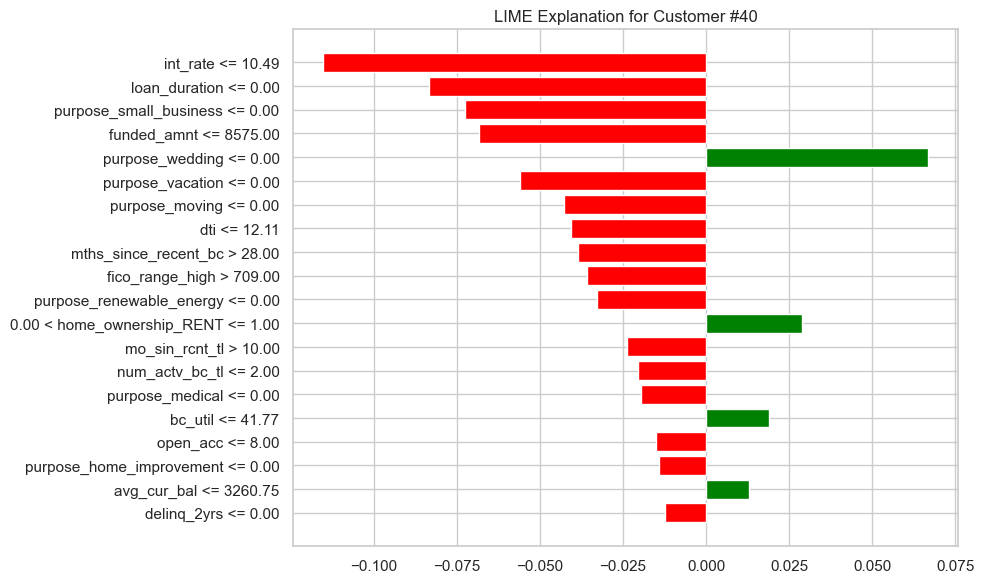

In [48]:
X_train_sample = X_train_full.sample(n=5000, random_state=42).values
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_sample,  # <--- The Correct Approach
    feature_names=feature_names,
    class_names=['Paid', 'Default'],
    mode='classification',
    verbose=False,
    random_state=42
)

# 3. Explain the specific instance
print(f"Explain instance #{customer_idx}...")
exp = lime_explainer.explain_instance(
    data_row=customer_data.values[0], 
    predict_fn=xgb_model.predict_proba,
    num_features=20
)

# Show plot
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Customer #{customer_idx}")
plt.tight_layout()
plt.show()

### 3. ICE

💡 Simulating: What if Customer #40 lowers their avg_cur_bal?
✅ ADVICE: If the customer reduces avg_cur_bal to 5788.0, they will likely be approved.


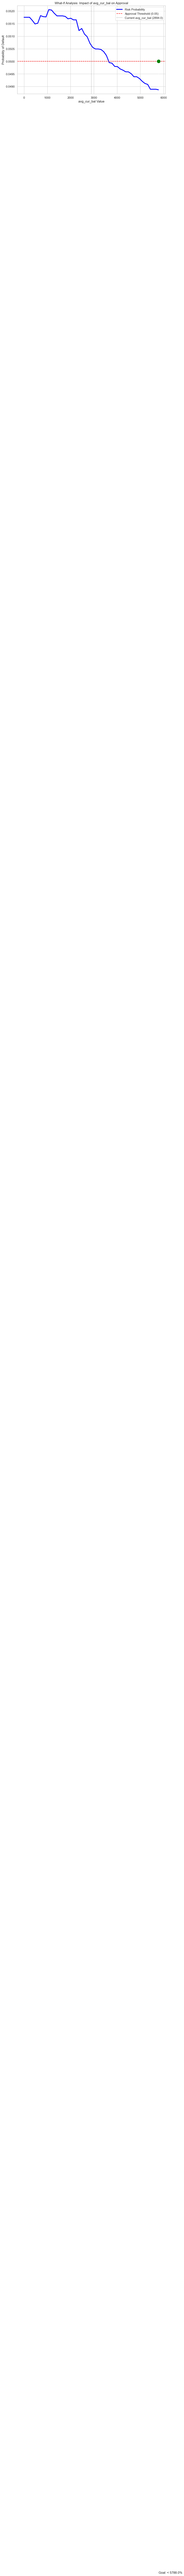

In [ ]:
feature_to_improve = 'avg_cur_bal' # Usually the most actionable feature
current_val = customer_data[feature_to_improve].values[0]

print(f"💡 Simulating: What if Customer #{customer_idx} lowers their {feature_to_improve}?")

min_val = 0
max_val = current_val * 2
simulation_range = np.linspace(min_val, max_val, 50)

# Create a synthetic dataset where we only change this one feature
X_sim = pd.concat([customer_data] * 50, ignore_index=True)
X_sim[feature_to_improve] = simulation_range

# Predict on this synthetic data
new_probs = xgb_model.predict_proba(X_sim)[:, 1]

# Plot ICE Curve (Individual Conditional Expectation)
plt.figure(figsize=(10, 6))
plt.plot(simulation_range, new_probs, color='blue', linewidth=3, label='Risk Probability')

# Add markers
plt.axhline(THRESHOLD, color='red', linestyle='--', label=f'Approval Threshold ({THRESHOLD})')
plt.axvline(current_val, color='grey', linestyle=':', label=f'Current {feature_to_improve} ({current_val:.1f})')

# Find intersection (The target value)
# Simple logic to find where prob drops below threshold
qualifying_indices = np.where(new_probs < THRESHOLD)[0]
if len(qualifying_indices) > 0:
    target_val = simulation_range[qualifying_indices[-1]] # The highest value that is still safe
    plt.scatter(target_val, THRESHOLD, color='green', s=150, zorder=5)
    plt.annotate(f"Goal: < {target_val:.1f}%", (target_val, THRESHOLD), 
                 xytext=(target_val-5, THRESHOLD-0.1), arrowprops=dict(arrowstyle="->"))
    
    print(f"✅ ADVICE: If the customer reduces {feature_to_improve} to {target_val:.1f}, they will likely be approved.")
else:
    print(f"⚠️ Even reducing {feature_to_improve} to 0 is not enough. They need to improve other features too.")

plt.title(f"What-If Analysis: Impact of {feature_to_improve} on Approval")
plt.xlabel(f"{feature_to_improve} Value")
plt.ylabel("Probability of Default")
plt.legend()
plt.show()
